In [29]:
import tensorflow as tf
import numpy as np
import pandas as pd
import cv2
import os
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

In [25]:
import matplotlib.pyplot as plt
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1, keepdims = True)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Dataset

In [2]:
DATASET_DIR = 'dataset'
TRAIN_DIR = os.path.join(DATASET_DIR, 'train')
TEST_DIR = os.path.join(DATASET_DIR, 'test1')

IMG_WIDTH = 64
IMG_HEIGHT = 64
IMG_SIZE = (IMG_WIDTH, IMG_HEIGHT)
TEST_SIZE = 0.2
EPOCHS = 20
NUM_CATEGORIES = 2


## Load train dataset

In [3]:
train_images = []
train_labels = []
for image_name in tqdm(os.listdir(TRAIN_DIR)):
    img = cv2.imread(os.path.join(TRAIN_DIR, image_name))
    if img is None:
        print("Fail to load {}".format(image_name))
        continue
    # img = img/255
    try:
        img = cv2.resize(img, dsize=IMG_SIZE)
    except:
        print("Fail to load {}".format(image_name))

    train_images.append(img)
    if 'cat' in image_name:
        train_labels.append(0)
    else:
        train_labels.append(1)

# train_labels = tf.keras.utils.to_categorical(train_labels)
train_images = np.array(train_images)
train_labels = np.array(train_labels)
np.save('train_images', train_images)
np.save('train_labels', train_labels)

100%|██████████| 25000/25000 [01:23<00:00, 301.12it/s]


In [4]:
train_images = np.load('train_images.npy')
train_labels = np.load('train_labels.npy')

In [5]:

train_images = train_images / 255
X_train, X_test, y_train, y_test = train_test_split(
    train_images,
    train_labels,
    test_size=TEST_SIZE,
    random_state=1,
    shuffle=True,
)

In [6]:
# for i in range(5):
#     cv2.imshow('', X_train[i])
#     print(y_train[i])
#     cv2.waitKey(0)
#     cv2.destroyAllWindows()

In [7]:
print(X_train[0].shape)
print(X_train[0])
print(y_train[:5])

(64, 64, 3)
[[[0.08235294 0.40784314 0.29803922]
  [0.10196078 0.44705882 0.33333333]
  [0.0627451  0.21568627 0.12941176]
  ...
  [0.21568627 0.35294118 0.31372549]
  [0.03529412 0.18039216 0.13333333]
  [0.16470588 0.4627451  0.37254902]]

 [[0.         0.23137255 0.1372549 ]
  [0.01176471 0.13333333 0.05882353]
  [0.         0.10588235 0.02352941]
  ...
  [0.00392157 0.05882353 0.02352941]
  [0.04313725 0.38823529 0.29411765]
  [0.13333333 0.35294118 0.2627451 ]]

 [[0.01960784 0.30588235 0.2       ]
  [0.09411765 0.15294118 0.08627451]
  [0.03529412 0.17254902 0.09411765]
  ...
  [0.04705882 0.36862745 0.23921569]
  [0.11372549 0.43529412 0.32941176]
  [0.07843137 0.38823529 0.26666667]]

 ...

 [[0.17254902 0.27843137 0.37254902]
  [0.08627451 0.16470588 0.16078431]
  [0.16078431 0.27058824 0.31372549]
  ...
  [0.03529412 0.10196078 0.23137255]
  [0.04705882 0.10980392 0.25098039]
  [0.05098039 0.11372549 0.25882353]]

 [[0.10196078 0.17254902 0.19215686]
  [0.21176471 0.2745098  

# Model

In [8]:
def get_model():
    model = tf.keras.models.Sequential()
        
    model.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu', input_shape=(IMG_WIDTH, IMG_HEIGHT, 3)))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))

    model.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))

    model.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))

    
    model.add(tf.keras.layers.Flatten())

    model.add(tf.keras.layers.Dense(units=256, activation='relu'))
    model.add(tf.keras.layers.Dense(units=256, activation='relu'))
    model.add(tf.keras.layers.Dense(units=256, activation='relu'))
    model.add(tf.keras.layers.Dropout(0.5))

    model.add(tf.keras.layers.Dense(2, activation='softmax'))

    model.compile(
        optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),
        loss=tf.keras.losses.CategoricalCrossentropy(),
        metrics=['accuracy']
    )
    
    # model.summary()

    return model

In [9]:
# Disable GPU
# tf.config.set_visible_devices([], 'GPU')

if tf.test.gpu_device_name():
    print('GPU found')
else:
    print("No GPU found")

GPU found


# Training

## Load pre-trained model or Initialize new model

### Load pretrained-model

In [ ]:
MODEL_PATH = 'CNN_0.81.h5'
model = tf.keras.models.load_model(MODEL_PATH)

### Initialize new model

In [ ]:
model = get_model()

## Train model

In [ ]:
model.fit(X_train, y_train, epochs=20)
model.evaluate(X_test, y_test)
model.save('temp.h5')
del model

# Evaluation

In [42]:
model = tf.keras.models.load_model(MODEL_PATH)

In [43]:
y_pred = model.predict(X_test)
y_pred = tf.argmax(y_pred, axis=1)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.82      0.78      0.80      2517
           1       0.79      0.83      0.81      2483

    accuracy                           0.81      5000
   macro avg       0.81      0.81      0.81      5000
weighted avg       0.81      0.81      0.81      5000



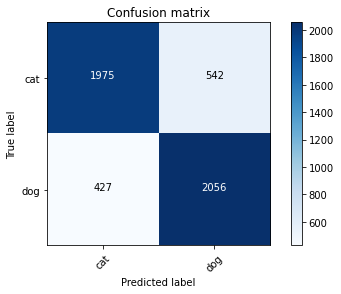

In [47]:
cm = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cm, classes=['cat', 'dog'])